In [17]:
import pandas as pd

In [51]:
chicago = pd.read_csv('airbnb_chicago_post_preprocessing_all.csv')

In [52]:
pd.set_option('display.max_columns', None)
chicago.head(5)

,Airbnb Host ID,Airbnb Property ID,City_x,superhost_period_all,Superhost,numReviews_pastYear,numCancel_pastYear,prop_5_StarReviews_pastYear,numReserv_pastYear,hostResponseAverage_pastYear,available_days,available_days_aveListedPrice,booked_days,booked_days_avePrice,Property Type,Listing Type,Zipcode,Bedrooms,Bathrooms,Neighborhood,Max Guests,Cleaning Fee (USD),Minimum Stay,Number of Photos,Pets Allowed,Instantbook Enabled,Nightly Rate,Number of Reviews,Rating Overall,revenue,occupancy_rate,tract_superhosts_ratio,booked_days_period_city,tract_booking_share
0,2613,2384,Chicago,5,1,31.0,0.0,1.000000,39.0,100.0,162.0,54.703704,25.0,60.920000,Condominium,Private room,60637,1.0,1.0,Hyde Park,1.0,25.0,2.0,26.0,False,0,50.00,53.0,100.0,1523.0,0.154321,0.300000,104924,0.001048
1,2613,2384,Chicago,6,1,35.0,0.0,1.000000,46.0,100.0,190.0,54.789474,18.0,50.277778,Condominium,Private room,60637,1.0,1.0,Hyde Park,1.0,25.0,2.0,26.0,False,0,54.00,59.0,100.0,905.0,0.094737,0.181818,68005,0.000353
2,2613,2384,Chicago,7,1,27.0,0.0,1.000000,41.0,100.0,210.0,57.561905,90.0,55.055556,Condominium,Private room,60637,1.0,1.0,Hyde Park,1.0,25.0,2.0,26.0,False,0,52.50,67.0,100.0,4955.0,0.428571,0.166667,134202,0.001185
3,2613,2384,Chicago,8,1,31.0,0.0,1.000000,47.0,100.0,163.0,59.411043,26.0,60.384615,Condominium,Private room,60637,1.0,1.0,Hyde Park,1.0,25.0,2.0,26.0,False,0,59.75,78.0,100.0,1570.0,0.159509,1.000000,132913,0.000196
4,2613,2384,Chicago,9,1,39.0,0.0,0.974359,53.0,100.0,189.0,55.941799,38.0,63.289474,Condominium,Private room,60637,1.0,1.0,Hyde Park,1.0,25.0,2.0,26.0,False,0,50.00,92.0,100.0,2405.0,0.201058,0.666667,118284,0.000778


In [53]:
chcago_lead = pd.DataFrame({
    'Airbnb Host ID': chicago['Airbnb Host ID'],
    'superhost_period_all' : chicago['superhost_period_all'],
    'Superhost': chicago['Superhost']
}).drop_duplicates()

In [54]:
# Sorting the dataframe by Host ID and period
chcago_lead = chcago_lead.sort_values(by=['Airbnb Host ID', 'superhost_period_all'])

# Creating the new column 'Next_Period_Superhost'
chcago_lead['Next_Period_Superhost'] = chcago_lead.groupby('Airbnb Host ID')['Superhost'].shift(-1)

In [55]:

# Merge this DataFrame back with the original DataFrame
# This will apply the next period superhost status of each host to all of its properties
chicago = chicago.merge(chcago_lead, on=['Airbnb Host ID', 'superhost_period_all', 'Superhost'], how='left')

# Check for missing values and handle them as needed
chicago = chicago.drop_duplicates()

# Now you can continue with your analysis, feature engineering, and model training
# ...


In [56]:
chicago = chicago.drop(columns = 'City_x')

## Improved 1

In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Define categorical and numerical columns
categorical_cols = ['Property Type', 'Listing Type', 'Neighborhood', 'Pets Allowed']
numerical_cols = [col for col in chicago.columns if col not in categorical_cols + ['Airbnb Host ID', 'Airbnb Property ID', 'superhost_period_all', 'Next_Period_Superhost']]

# Preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Define the logistic regression model with balanced class weights
model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=2000)

# Create a pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

# Parameter grid for hyperparameter tuning
param_grid = {
    'model__C': [0.05, 0.1, 0.5, 1, 5],
    'model__solver': ['liblinear', 'lbfgs']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', verbose=1)

# Splitting data: Train on periods 1-18, Test on periods 18-20
training_data = chicago[chicago['superhost_period_all'] < 14]
testing_data = chicago[(chicago['superhost_period_all'] >= 14)]

X_train = training_data[numerical_cols + categorical_cols]
y_train = training_data['Next_Period_Superhost']
X_test = testing_data[numerical_cols + categorical_cols]
y_test = testing_data['Next_Period_Superhost']
y_train = y_train.fillna(0)
y_test = y_test.fillna(0)

# Fitting the model
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best parameters:", grid_search.best_params_)

# Making predictions with the best model
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

# Predicted probabilities for the test data
probabilities = best_model.predict_proba(X_test)[:, 1]  # Probability of class 1

# Model evaluation
print("Test Classification Report:\n", classification_report(y_test, predictions))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, predictions))

# Adding predictions and probabilities back to the DataFrame for analysis
testing_data['predicted_superhost_status'] = predictions
testing_data['predicted_superhost_probabilities'] = probabilities

# Display a snippet of the testing data
print("Testing Data with Predictions and Probabilities:\n", testing_data)

# Get the train dataset with predicted probabilities
train_predictions = best_model.predict(X_train)
train_probabilities = best_model.predict_proba(X_train)[:, 1]  # Probability of class 1
training_data['predicted_superhost_status'] = train_predictions
training_data['predicted_superhost_probabilities'] = train_probabilities
print("Training Data with Predictions and Probabilities:\n", training_data)

# Combine train and test datasets
combined_data = pd.concat([training_data, testing_data], ignore_index=True)
print("Combined Data:\n", combined_data)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'model__C': 0.05, 'model__solver': 'liblinear'}
Test Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.72      0.80     18752
         1.0       0.70      0.89      0.78     13981

    accuracy                           0.79     32733
   macro avg       0.80      0.80      0.79     32733
weighted avg       0.81      0.79      0.79     32733

Test Confusion Matrix:
 [[13439  5313]
 [ 1557 12424]]
Testing Data with Predictions and Probabilities:
        Airbnb Host ID  Airbnb Property ID  superhost_period_all  Superhost  \
9                2613                2384                    14          1   
10               2613                2384                    15          1   
11               2613                2384                    16          1   
12               2613                2384                    17          1   
13               2613 

/var/folders/cd/2r5xq6n95ddgb553kj2955940000gn/T/ipykernel_48532/3994414514.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_data['predicted_superhost_status'] = predictions
/var/folders/cd/2r5xq6n95ddgb553kj2955940000gn/T/ipykernel_48532/3994414514.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_data['predicted_superhost_probabilities'] = probabilities
/var/folders/cd/2r5xq6n95ddgb553kj2955940000gn/T/ipykernel_48532/3994414514.py:76: SettingWithCopyWarning: 
A value is trying to be

In [58]:
classification_report(y_test, predictions)

'              precision    recall  f1-score   support\n\n         0.0       0.90      0.72      0.80     18752\n         1.0       0.70      0.89      0.78     13981\n\n    accuracy                           0.79     32733\n   macro avg       0.80      0.80      0.79     32733\nweighted avg       0.81      0.79      0.79     32733\n'

In [59]:
combined_data['predicted_superhost_probabilities_0'] = 1-combined_data['predicted_superhost_probabilities']
combined_data

,Airbnb Host ID,Airbnb Property ID,superhost_period_all,Superhost,numReviews_pastYear,numCancel_pastYear,prop_5_StarReviews_pastYear,numReserv_pastYear,hostResponseAverage_pastYear,available_days,available_days_aveListedPrice,booked_days,booked_days_avePrice,Property Type,Listing Type,Zipcode,Bedrooms,Bathrooms,Neighborhood,Max Guests,Cleaning Fee (USD),Minimum Stay,Number of Photos,Pets Allowed,Instantbook Enabled,Nightly Rate,Number of Reviews,Rating Overall,revenue,occupancy_rate,tract_superhosts_ratio,booked_days_period_city,tract_booking_share,Next_Period_Superhost,predicted_superhost_status,predicted_superhost_probabilities,predicted_superhost_probabilities_0
0,2613,2384,5,1,31.0,0.0,1.000000,39.0,100.0,162.0,54.703704,25.0,60.920000,Condominium,Private room,60637,1.0,1.0,Hyde Park,1.0,25.000000,2.0,26.0,False,0,50.00,53.0,100.0,1523.0,0.154321,0.300000,104924,0.001048,1.0,1.0,0.967260,0.032740
1,2613,2384,6,1,35.0,0.0,1.000000,46.0,100.0,190.0,54.789474,18.0,50.277778,Condominium,Private room,60637,1.0,1.0,Hyde Park,1.0,25.000000,2.0,26.0,False,0,54.00,59.0,100.0,905.0,0.094737,0.181818,68005,0.000353,1.0,1.0,0.967401,0.032599
2,2613,2384,7,1,27.0,0.0,1.000000,41.0,100.0,210.0,57.561905,90.0,55.055556,Condominium,Private room,60637,1.0,1.0,Hyde Park,1.0,25.000000,2.0,26.0,False,0,52.50,67.0,100.0,4955.0,0.428571,0.166667,134202,0.001185,1.0,1.0,0.980356,0.019644
3,2613,2384,8,1,31.0,0.0,1.000000,47.0,100.0,163.0,59.411043,26.0,60.384615,Condominium,Private room,60637,1.0,1.0,Hyde Park,1.0,25.000000,2.0,26.0,False,0,59.75,78.0,100.0,1570.0,0.159509,1.000000,132913,0.000196,1.0,1.0,0.977948,0.022052
4,2613,2384,9,1,39.0,0.0,0.974359,53.0,100.0,189.0,55.941799,38.0,63.289474,Condominium,Private room,60637,1.0,1.0,Hyde Park,1.0,25.000000,2.0,26.0,False,0,50.00,92.0,100.0,2405.0,0.201058,0.666667,118284,0.000778,1.0,1.0,0.977203,0.022797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68196,289257440,42713512,20,0,4.0,0.0,1.000000,0.0,100.0,27.0,33.814815,2.0,35.000000,House,Private room,60609,1.0,2.0,McKinley Park,2.0,64.190942,300.0,19.0,False,1,39.00,3.0,100.0,70.0,0.074074,0.157895,92329,0.004029,NaN,1.0,0.816269,0.183731
68197,169297663,42713595,20,0,22.0,6.0,1.000000,94.0,100.0,241.0,101.813278,45.0,103.200000,Condominium,Entire home/apt,60614,3.0,2.0,Lincoln Park,8.0,125.000000,2.0,14.0,False,1,177.00,7.0,100.0,4644.0,0.186722,0.333333,92329,0.002404,NaN,0.0,0.011408,0.988592
68198,289257440,42714387,20,0,4.0,0.0,1.000000,0.0,100.0,78.0,33.333333,41.0,34.268293,House,Private room,60608,1.0,2.0,McKinley Park,1.0,5.000000,2.0,20.0,False,1,29.00,2.0,100.0,1405.0,0.525641,0.157895,92329,0.004029,NaN,0.0,0.418808,0.581192
68199,289257440,42714699,20,0,4.0,0.0,1.000000,0.0,100.0,128.0,31.726562,68.0,33.029412,House,Private room,60608,1.0,2.0,McKinley Park,1.0,5.000000,2.0,19.0,False,1,29.00,19.0,96.0,2246.0,0.531250,0.157895,92329,0.004029,NaN,0.0,0.449886,0.550114


In [26]:
combined_data.to_csv('final_data.csv')

In [62]:
combined_data_20 = combined_data[combined_data['superhost_period_all']==20]

In [63]:
combined_data_20

,Airbnb Host ID,Airbnb Property ID,superhost_period_all,Superhost,numReviews_pastYear,numCancel_pastYear,prop_5_StarReviews_pastYear,numReserv_pastYear,hostResponseAverage_pastYear,available_days,available_days_aveListedPrice,booked_days,booked_days_avePrice,Property Type,Listing Type,Zipcode,Bedrooms,Bathrooms,Neighborhood,Max Guests,Cleaning Fee (USD),Minimum Stay,Number of Photos,Pets Allowed,Instantbook Enabled,Nightly Rate,Number of Reviews,Rating Overall,revenue,occupancy_rate,tract_superhosts_ratio,booked_days_period_city,tract_booking_share,Next_Period_Superhost,predicted_superhost_status,predicted_superhost_probabilities,predicted_superhost_probabilities_0
35474,2613,2384,20,1,36.0,0.0,0.972222,54.0,100.000000,187.0,77.352941,46.0,70.000000,Condominium,Private room,60637,1.0,1.0,Hyde Park,1.0,25.000000,2.0,26.0,False,0,65.0,178.0,100.0,3220.0,0.245989,0.181818,92329,0.003054,NaN,1.0,0.980503,0.019497
35481,5775,4505,20,1,28.0,0.0,0.892857,85.0,97.545455,10.0,90.600000,3.0,94.333333,Apartment,Entire home/apt,60623,3.0,1.0,Little Village,7.0,30.000000,2.0,19.0,False,1,80.0,394.0,96.0,283.0,0.300000,0.608696,92329,0.002307,NaN,1.0,0.941850,0.058150
35489,17928,7126,20,1,73.0,0.0,0.821918,75.0,100.000000,110.0,67.181818,29.0,90.000000,Apartment,Entire home/apt,60622,3.0,1.0,West Town/Noble Square,2.0,64.190942,2.0,7.0,False,0,70.0,384.0,93.0,2610.0,0.263636,0.488372,92329,0.006217,NaN,1.0,0.944932,0.055068
35496,33004,9811,20,0,109.0,2.0,0.779817,204.0,92.000000,125.0,98.040000,35.0,114.714286,Apartment,Entire home/apt,60614,1.0,1.0,Old Town,4.0,85.000000,4.0,13.0,False,1,125.0,49.0,92.0,4015.0,0.280000,0.384615,92329,0.008491,NaN,0.0,0.023296,0.976704
35502,33004,10945,20,0,109.0,2.0,0.779817,204.0,92.000000,164.0,130.762195,48.0,148.645833,Apartment,Entire home/apt,60614,2.0,1.0,Old Town,4.0,120.000000,4.0,8.0,False,1,150.0,17.0,91.0,7135.0,0.292683,0.666667,92329,0.004906,NaN,0.0,0.027181,0.972819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68196,289257440,42713512,20,0,4.0,0.0,1.000000,0.0,100.000000,27.0,33.814815,2.0,35.000000,House,Private room,60609,1.0,2.0,McKinley Park,2.0,64.190942,300.0,19.0,False,1,39.0,3.0,100.0,70.0,0.074074,0.157895,92329,0.004029,NaN,1.0,0.816269,0.183731
68197,169297663,42713595,20,0,22.0,6.0,1.000000,94.0,100.000000,241.0,101.813278,45.0,103.200000,Condominium,Entire home/apt,60614,3.0,2.0,Lincoln Park,8.0,125.000000,2.0,14.0,False,1,177.0,7.0,100.0,4644.0,0.186722,0.333333,92329,0.002404,NaN,0.0,0.011408,0.988592
68198,289257440,42714387,20,0,4.0,0.0,1.000000,0.0,100.000000,78.0,33.333333,41.0,34.268293,House,Private room,60608,1.0,2.0,McKinley Park,1.0,5.000000,2.0,20.0,False,1,29.0,2.0,100.0,1405.0,0.525641,0.157895,92329,0.004029,NaN,0.0,0.418808,0.581192
68199,289257440,42714699,20,0,4.0,0.0,1.000000,0.0,100.000000,128.0,31.726562,68.0,33.029412,House,Private room,60608,1.0,2.0,McKinley Park,1.0,5.000000,2.0,19.0,False,1,29.0,19.0,96.0,2246.0,0.531250,0.157895,92329,0.004029,NaN,0.0,0.449886,0.550114


In [85]:

# Filter the DataFrame for rows where predicted == 1
predicted_ones = combined_data_20[combined_data_20['predicted_superhost_status'] == 1.0]

# Count the occurrences of each unique value in the 'pets_allowed' column
count_by_pets_allowed = predicted_ones['Number of Photos'].value_counts()
count_by_pets_allowed

21.0     84
15.0     78
11.0     78
9.0      78
13.0     78
         ..
66.0      1
91.0      1
70.0      1
106.0     1
90.0      1
Name: Number of Photos, Length: 89, dtype: int64

In [83]:
abc = pd.DataFrame(count_by_pets_allowed)
abc.sort_index().head(50)

,Number of Photos
1.0,2
3.0,3
4.0,10
5.0,15
6.0,22
7.0,33
8.0,50
9.0,78
10.0,76
11.0,78


In [27]:
# Extract the coefficients of the logistic regression model
coefficients = best_model.named_steps['model'].coef_[0]

# Check if one-hot encoding was used and retrieve feature names from the preprocessor
if isinstance(best_model.named_steps['preprocessor'].named_transformers_['cat'], OneHotEncoder):
    # Get the one-hot encoding feature names
    one_hot_encoder = best_model.named_steps['preprocessor'].named_transformers_['cat']
    
    # Check for the appropriate method to use based on the scikit-learn version
    if hasattr(one_hot_encoder, 'get_feature_names_out'):  # For scikit-learn 0.21 and later
        encoded_cols = one_hot_encoder.get_feature_names_out(input_features=categorical_cols)
    else:  # For older versions of scikit-learn
        encoded_cols = one_hot_encoder.get_feature_names(input_features=categorical_cols)
    
    # Combine numerical and one-hot encoded categorical feature names
    feature_names = numerical_cols + list(encoded_cols)
else:
    # If one-hot encoding wasn't used, the feature names are just the columns of X_train
    feature_names = list(X_train.columns)

# Take the absolute values of the coefficients as importance scores
importance = abs(coefficients)

# Ensure that the lengths of feature_names and importance match
if len(feature_names) == len(importance):
    # Create a DataFrame for feature importance
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    })

    # Sort the DataFrame by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Print or visualize the feature importance
    print("Feature Importance:\n", feature_importance_df)
else:
    print("Error: The lengths of feature_names and importance do not match.")


Feature Importance:
                                 Feature    Importance
2                    numCancel_pastYear  1.168414e+00
0                             Superhost  1.121567e+00
20                       Rating Overall  7.241107e-01
3           prop_5_StarReviews_pastYear  6.620645e-01
5          hostResponseAverage_pastYear  4.317981e-01
..                                  ...           ...
60           Property Type_Private room  2.359195e-03
141             Neighborhood_River West  1.828915e-03
39           Property Type_Entire Floor  2.042928e-04
63   Property Type_Private room in dorm  8.061159e-05
79              Property Type_Timeshare  2.831696e-07

[158 rows x 2 columns]


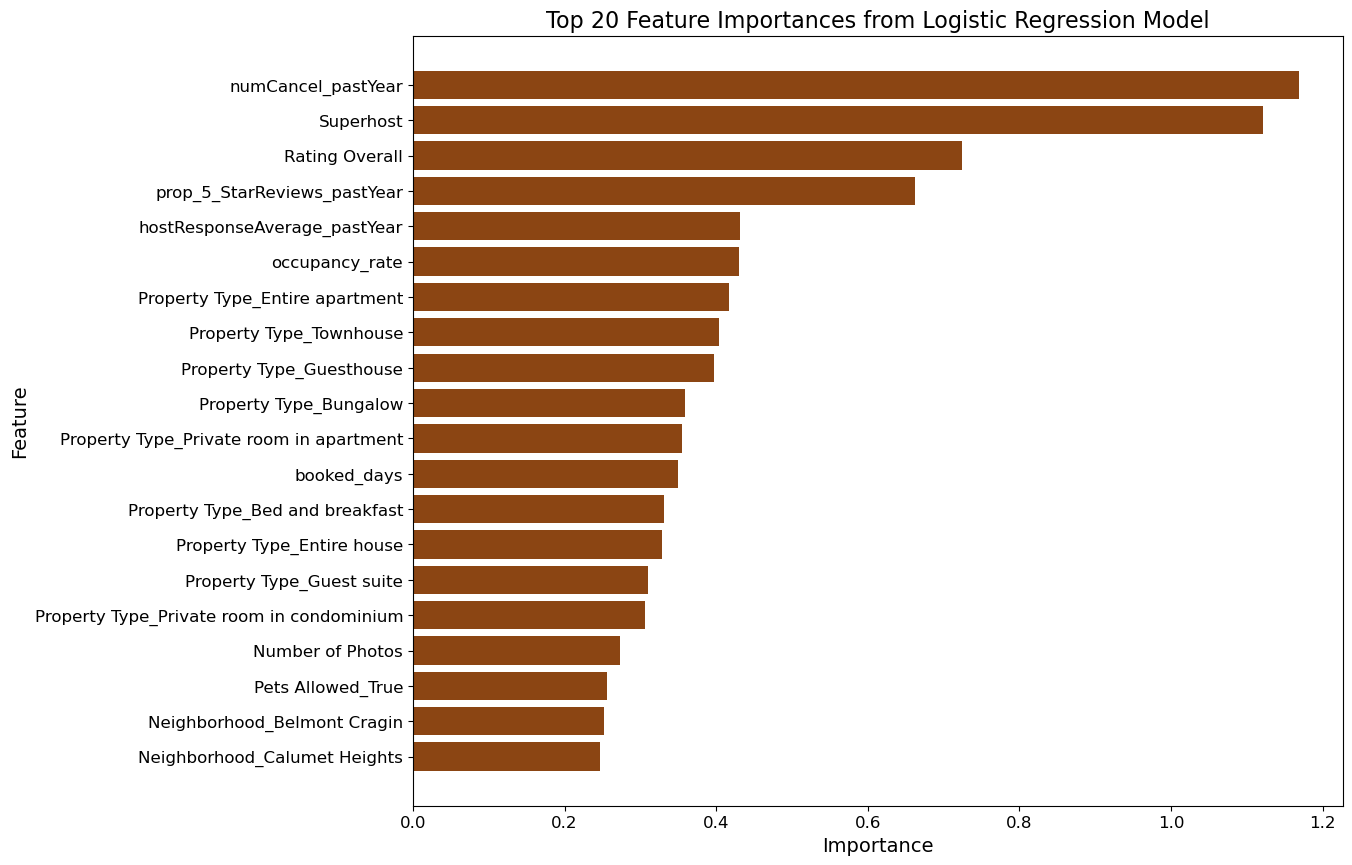

In [32]:
import matplotlib.pyplot as plt

# Assuming feature_importance_df is already sorted in descending order of importance
# Selecting the top 20 features
top_20_features = feature_importance_df.head(20)

# Define the color as brown
bar_color = 'saddlebrown'

# Plotting the feature importances for the top 20 features in a bar chart
plt.figure(figsize=(12, 10))
plt.barh(top_20_features['Feature'], top_20_features['Importance'], color=bar_color)
plt.xlabel('Importance', fontsize=14)  # Increase font size for x-label
plt.ylabel('Feature', fontsize=14)     # Increase font size for y-label
plt.title('Top 20 Feature Importances from Logistic Regression Model', fontsize=16)  # Title font size
plt.xticks(fontsize=12)  # Font size for x-ticks
plt.yticks(fontsize=12)  # Font size for y-ticks
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()
